# 📊🧪 Literature Screening – Model Evaluation  
Aggregate results for **train** and **test** splits, report metrics and confusion matrices separately.

In [1]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 1 – Imports and helpers 🔌               ║
# ╚════════════════════════════════════════════════╝
import json
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             confusion_matrix, classification_report)

sns.set(style="whitegrid")

In [2]:
# ╔════════════════════════════════════════════════╗  
# ║ Cell 2 – Discover model folders 🔍            ║  
# ╚════════════════════════════════════════════════╝  

notebook_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()  
  
# Path to the outputs/v4 directory that holds the model folders  
outputs_root = (notebook_dir / "outputs" / "v4").resolve()  
  
if not outputs_root.exists():  
    raise RuntimeError(f"Could not find outputs directory at: {outputs_root}")  
  
# Grab every sub-directory (each is a model name)  
model_dirs = [d for d in outputs_root.iterdir() if d.is_dir() and d.name != "datasets"]  
  
if not model_dirs:  
    raise RuntimeError(f"No model result folders found inside '{outputs_root}/'")  
  
print("Models found:", ", ".join(d.name for d in model_dirs))  

Models found: gpt-4.1


In [3]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 3 – Load predictions per split 🗄️        ║
# ╚════════════════════════════════════════════════╝
all_predictions = defaultdict(dict)  # {model: {split: DataFrame}}

for mdir in model_dirs:
    for split in ("train", "test"):
        preds_dir = mdir / split / "predictions"
        if not preds_dir.exists():
            continue

        rows = []
        for jf in preds_dir.glob("*.json"):
            with open(jf, encoding="utf-8") as f:
                data = json.load(f)
            rows.append({
                "id"          : jf.stem,
                "ground_truth": data.get("ground_truth"),
                "prediction"  : data.get("prediction")
            })
        if rows:
            df = pd.DataFrame(rows)
            all_predictions[mdir.name][split] = df
            unparsable = (df["prediction"] == "ParseError").sum()
            print(f"{mdir.name} [{split}] -> {len(df):,} rows, {unparsable} unparsable")


gpt-4.1 [train] -> 518 rows, 0 unparsable
gpt-4.1 [test] -> 130 rows, 0 unparsable


In [4]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 4 – Build metrics table 📋               ║
# ╚════════════════════════════════════════════════╝
metrics = []

for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["prediction"].isin(["Included", "Excluded"])]
        unparsed = len(df) - len(parsable)

        if len(parsable) == 0:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["prediction"]

        metrics.append({
            "model"      : model,
            "split"      : split,
            "n_total"    : len(df),
            "n_unparsed" : unparsed,
            "accuracy"   : accuracy_score(y_true, y_pred),
            "precision"  : precision_score(y_true, y_pred, pos_label="Included"),
            "recall"     : recall_score(y_true, y_pred,  pos_label="Included"),
            "f1"         : f1_score(y_true, y_pred,      pos_label="Included")
        })

metrics_df = (pd.DataFrame(metrics)
              .set_index(["model", "split"])
              .sort_values(["model", "split"]))

metrics_df.style.format({
    "accuracy" : "{:.3f}",
    "precision": "{:.3f}",
    "recall"   : "{:.3f}",
    "f1"       : "{:.3f}"
})


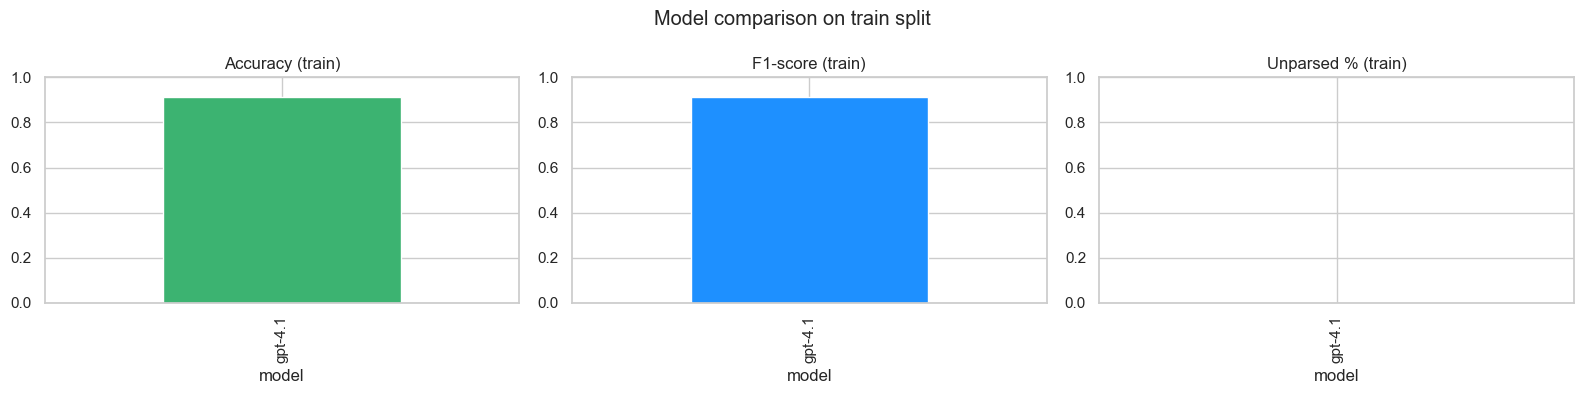

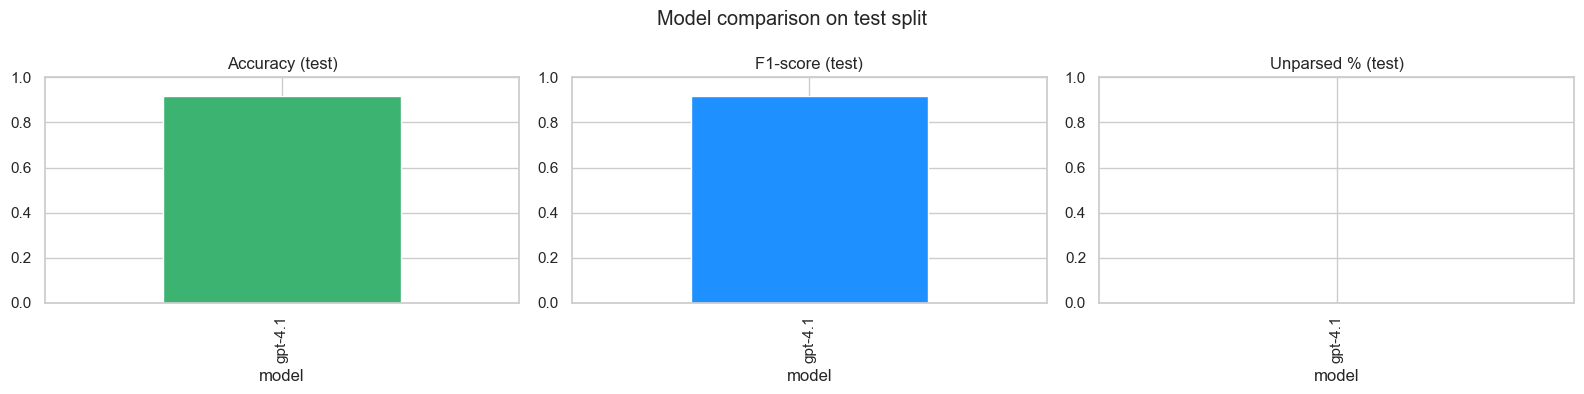

In [5]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 5 – Bar charts for each split 📊         ║
# ╚════════════════════════════════════════════════╝
for split in ("train", "test"):
    subset = metrics_df.xs(split, level="split")
    if subset.empty:
        continue

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    subset["accuracy"].plot(kind="bar", ax=axes[0], color="mediumseagreen")
    axes[0].set_title(f"Accuracy ({split})")
    axes[0].set_ylim(0, 1)

    subset["f1"].plot(kind="bar", ax=axes[1], color="dodgerblue")
    axes[1].set_title(f"F1-score ({split})")
    axes[1].set_ylim(0, 1)

    (subset["n_unparsed"] / subset["n_total"]).plot(kind="bar",
                                                    ax=axes[2],
                                                    color="indianred")
    axes[2].set_title(f"Unparsed % ({split})")
    axes[2].set_ylim(0, 1)

    plt.suptitle(f"Model comparison on {split} split")
    plt.tight_layout()
    plt.show()


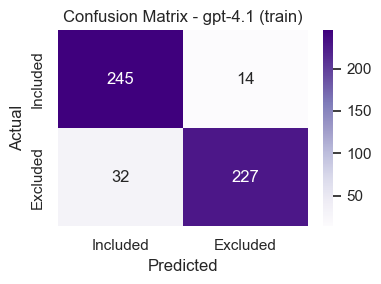

Classification report for gpt-4.1 (train)
              precision    recall  f1-score   support

    Excluded      0.942     0.876     0.908       259
    Included      0.884     0.946     0.914       259

    accuracy                          0.911       518
   macro avg      0.913     0.911     0.911       518
weighted avg      0.913     0.911     0.911       518



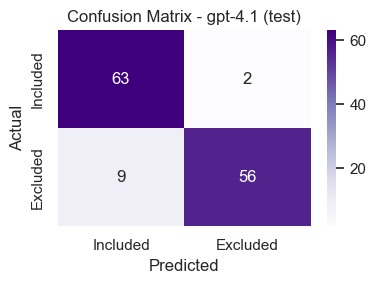

Classification report for gpt-4.1 (test)
              precision    recall  f1-score   support

    Excluded      0.966     0.862     0.911        65
    Included      0.875     0.969     0.920        65

    accuracy                          0.915       130
   macro avg      0.920     0.915     0.915       130
weighted avg      0.920     0.915     0.915       130



In [6]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 6 – Confusion matrices 🔲                ║
# ╚════════════════════════════════════════════════╝
for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["prediction"].isin(["Included", "Excluded"])]
        if parsable.empty:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["prediction"]

        cm = confusion_matrix(y_true, y_pred, labels=["Included", "Excluded"])

        plt.figure(figsize=(4, 3))
        sns.heatmap(cm,
                    annot=True,
                    fmt="d",
                    cmap="Purples",
                    xticklabels=["Included", "Excluded"],
                    yticklabels=["Included", "Excluded"])
        plt.title(f"Confusion Matrix - {model} ({split})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        print(f"Classification report for {model} ({split})")
        print(classification_report(y_true, y_pred, digits=3))


## ✔️ Evaluation complete  
You now get clear, separate insights for train and test splits across every model folder found under **outputs/**.